In [1]:
%load_ext autoreload
%autoreload 2

# retina quality
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import G, c
from astropy import units as u
from scipy.stats import rv_histogram
from scipy.stats import skew, kurtosis, moment

In [3]:
cd /Users/lambwg/Documents/Vanderbilt/Research/pop_synth//

/Users/lambwg/Documents/Vanderbilt/Research/pop_synth


In [4]:
from scripts import pop_synth

In [5]:
rc_params = {#"backend": "pdf", 
             "axes.labelsize": 10, "lines.markersize": 4,
 "font.size": 10, "xtick.top": True, "ytick.right": True,
 "xtick.major.size": 6, "xtick.minor.size": 3, "ytick.major.size": 6,
 "ytick.minor.size": 3, "xtick.major.width": 0.5, "ytick.major.width": 0.5,
 "xtick.minor.width": 0.5, "ytick.minor.width": 0.5,
 "lines.markeredgewidth": 1, "axes.linewidth": 1.2, "legend.fontsize": 7,
 "xtick.labelsize": 10, "xtick.direction": "in", "xtick.minor.visible": True,
 "xtick.major.top": True, "xtick.minor.top": True, "ytick.labelsize": 10,
 "ytick.direction": "in", "ytick.minor.visible": True,
 "ytick.major.right": True, "ytick.minor.right": True, "savefig.dpi": 400,
 "path.simplify": True, "font.family": "serif", "font.serif": "Times",
 "text.usetex": False, "figure.figsize": [3.5503666805036667,
                                         2.1942472810764047]}

plt.rcParams.update(rc_params)

In [12]:
fyr = 1/(365.24 * 86400)

script to compute statistics on the background for various quantities

In [6]:
# load some precomputed backgrounds!
h2cf = np.load('./data/hc2f_10k_model1.npy')[:99999]
for ii in range(2, 6):
    h2cf = np.dstack((h2cf, np.load(f'./data/hc2f_10k_model{ii}.npy')[:99999]))

In [7]:
h2cf.shape

(99999, 30, 5)

# functions to transform between quantities

In [8]:
def hc(hc2f, freqs):
    return np.sqrt(hc2f)

def omega(hc2f, freqs):
    H0 = (70 * u.km/u.s/u.Mpc).to(1/u.s).value
    return (2*np.pi**2)/(3*H0**2) * freqs[None, :, None]**2 * hc2f

def S_h(hc2f, freqs):
    return hc2f / freqs[None, :, None]

def rho2(hc2f, freqs):
    return hc2f / (12 * np.pi**2 * freqs[None, :, None]**3 / freqs[0])

def rho(hc2f, freqs):
    return np.sqrt(rho2(hc2f, freqs))

def log10_rho(hc2f, freqs):
    return 0.5 * np.log10(rho2(hc2f, freqs))

In [9]:
Tspan = 20 * 365.24 * 86400
freqs = np.arange(1, 31) / Tspan

## compute means and variances for each of these models

In [12]:
fyr = 1 / (365.24 * 86400)

quantities = {'h_c^2(f)': None, 'Omega(f)': omega,
              'S_h(f) [s]': S_h, 'rho(f) [s]}': rho,
              'rho^2(f) [s^2]': rho2, 'h_c(f)': hc,
              'log_{10}(rho(f) [s])': log10_rho}

amplitudes = np.array([
    10.**np.arange(-70, -50)[:, None] * (freqs[None, :]/fyr),
    10.**np.arange(-25, -5)[:, None] * (freqs[None, :]/fyr)**5.,
    10.**np.arange(-55, -35)[:, None] * (freqs[None, :]/fyr)**-1.,
    10.**np.arange(-26, -6)[:, None] * (freqs[None, :]/fyr)**-(11/6),
    10.**np.arange(-45, -25)[:, None] * (freqs[None, :]/fyr)**-5.,
    10.**np.arange(-40, -20)[:, None] * (freqs[None, :]/fyr)**(7/3),
    10.**np.arange(-15, 5)[:, None] * (freqs[None, :]/fyr)**(11/3),
])

In [13]:
amplitudes.shape

(7, 20, 30)

/var/folders/n5/tlyhfd1j5s7gm9fxj02byc0c0000gn/T/ipykernel_9765/416567136.py:18: RuntimeWarning: divide by zero encountered in log10
  return 0.5 * np.log10(rho2(hc2f, freqs))


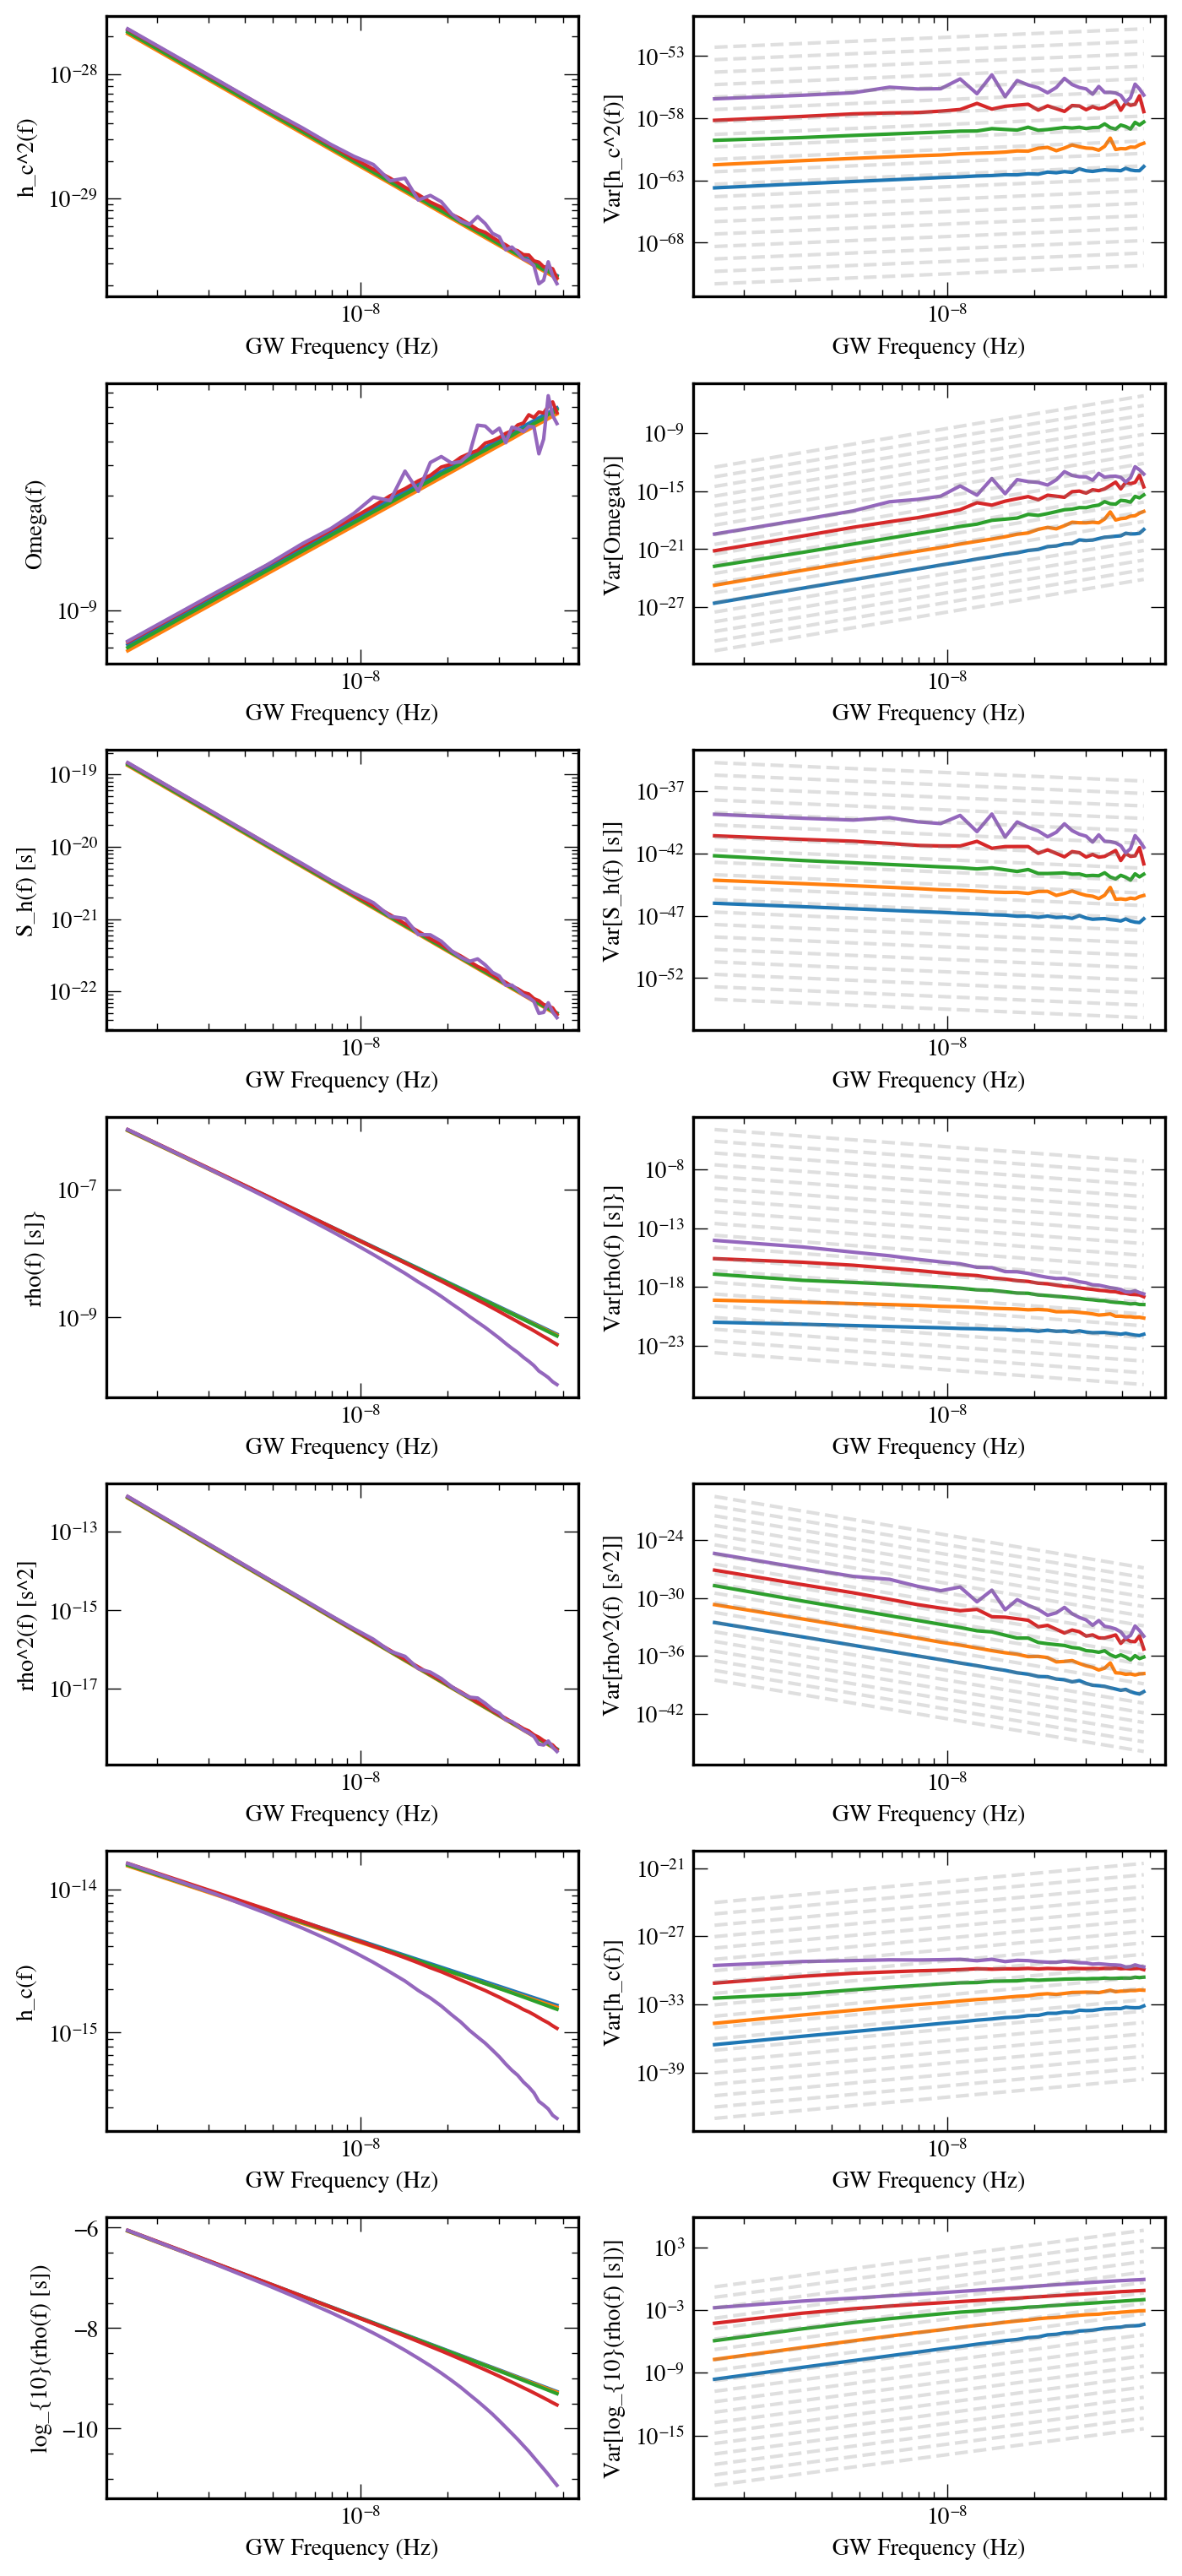

In [183]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047*7]}
plt.rcParams.update(figsize_params)

fig, axes = plt.subplots(ncols=2, nrows=7, tight_layout=True,)

# plot mean and variance of each model for each quantity
for q, quant in enumerate(quantities):

    axs = axes[q]

    if quant==r'h_c^2(f)':
        quantity = h2cf
    else:
        quantity = quantities[quant](h2cf, freqs)  # compute the quantity
    
    # checking for infs
    if np.isneginf(quantity).any():
        quantity[np.isneginf(quantity)] = np.nan

    # compute the mean and variance across realisations
    mean = np.nanmean(quantity, axis=0)
    var = np.nanvar(quantity, axis=0)

    fyr = 1/(365.24*86400)

    for ii in range(h2cf.shape[-1]):  # plot models
        axs[0].plot(freqs, mean[:, ii], label=f'Model {ii}')
        axs[1].plot(freqs, var[:, ii], label=f'Model {ii}')
    
    #ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log') if quant != 'log_{10}(rho(f) [s])' else None
    axs[0].set_ylabel(quant)
    axs[0].set_xlabel(r'GW Frequency (Hz)')

    #ax.plot(f_mid, 1.4e-60 * (f_mid/fyr)**(1), c='k', ls='--', label=r'$f^1$')
    axs[1].set_xscale('log', base=10)
    axs[1].set_yscale('log', base=10)
    axs[1].set_ylabel('Var['+quant+']')
    axs[1].set_xlabel(r'GW Frequency (Hz)')

    [axs[1].plot(freqs, amplitudes[q, jj], c='grey', alpha=0.25, ls='--')
     for jj in range(20)]

# compute skewness

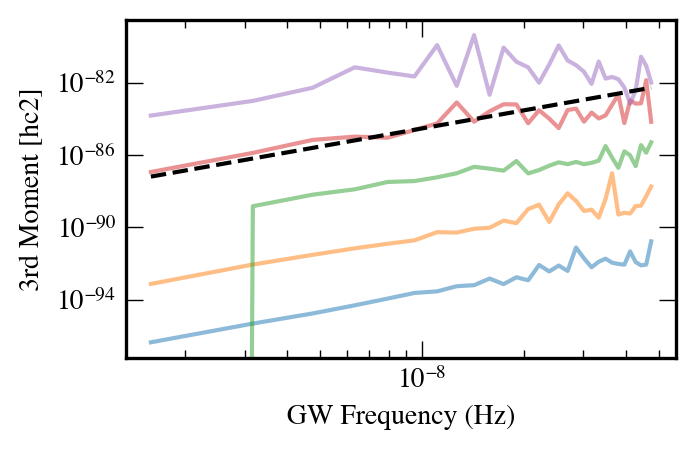

In [13]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

#fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True,)

moment3 = moment(h2cf, axis=0, nan_policy='omit', moment=3)

for ii in range(h2cf.shape[-1]):  # plot models
    plt.plot(freqs, moment3[:, ii], label=f'Model {ii}', alpha=0.5)
    
    #ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
    #axs[0].set_xscale('log')
    #axs[0].set_yscale('log') if quant != 'log_{10}(rho(f) [s])' else None
    #axs[0].set_ylabel(quant)
    #axs[0].set_xlabel(r'GW Frequency (Hz)')

plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlabel(r'GW Frequency (Hz)')
plt.ylabel('3rd Moment [hc2]')

plt.plot(freqs, 1.4e-83 * (freqs/fyr)**(10/3), c='k', ls='--', label=r'$f^{10/3}$')

    #[axs[1].plot(freqs, amplitudes[q, jj], c='grey', alpha=0.25, ls='--')
    # for jj in range(20)]

Model 2, frequency 1/T - third moment is negative

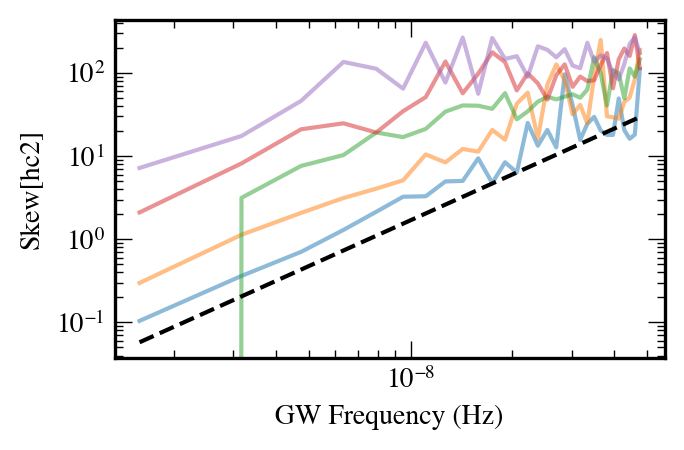

In [42]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

#fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True,)

skewness = skew(h2cf, axis=0, nan_policy='omit')

for ii in range(h2cf.shape[-1]):  # plot models
    plt.plot(freqs, skewness[:, ii], label=f'Model {ii}', alpha=0.5)
    
    #ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
    #axs[0].set_xscale('log')
    #axs[0].set_yscale('log') if quant != 'log_{10}(rho(f) [s])' else None
    #axs[0].set_ylabel(quant)
    #axs[0].set_xlabel(r'GW Frequency (Hz)')

plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylabel('Skew[hc2]')
plt.xlabel(r'GW Frequency (Hz)')

plt.plot(freqs, 1.4e1 * (freqs/fyr)**(11/6), c='k', ls='--', label=r'$f^{11/6}$')

    #[axs[1].plot(freqs, amplitudes[q, jj], c='grey', alpha=0.25, ls='--')
    # for jj in range(20)]

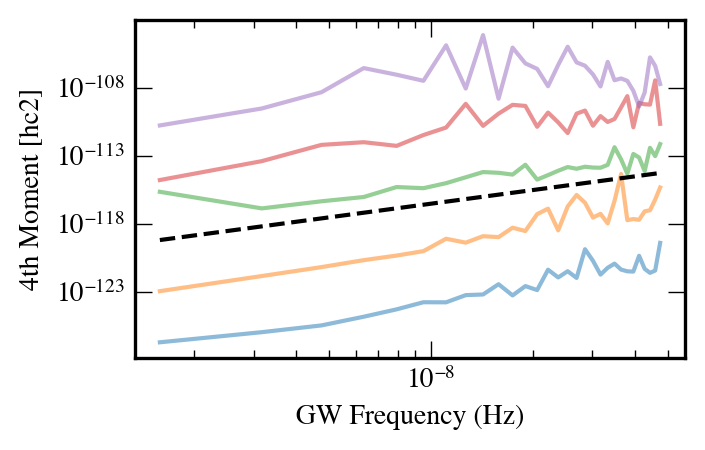

In [47]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

#fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True,)

moment4 = moment(h2cf, axis=0, nan_policy='omit', moment=4)

for ii in range(h2cf.shape[-1]):  # plot models
    plt.plot(freqs, moment4[:, ii], label=f'Model {ii}', alpha=0.5)
    
    #ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
    #axs[0].set_xscale('log')
    #axs[0].set_yscale('log') if quant != 'log_{10}(rho(f) [s])' else None
    #axs[0].set_ylabel(quant)
    #axs[0].set_xlabel(r'GW Frequency (Hz)')

plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlabel(r'GW Frequency (Hz)')
plt.ylabel('4th Moment [hc2]')

plt.plot(freqs, 1.4e-115 * (freqs/fyr)**(10/3), c='k', ls='--', label=r'$f^{11/6}$')

    #[axs[1].plot(freqs, amplitudes[q, jj], c='grey', alpha=0.25, ls='--')
    # for jj in range(20)]

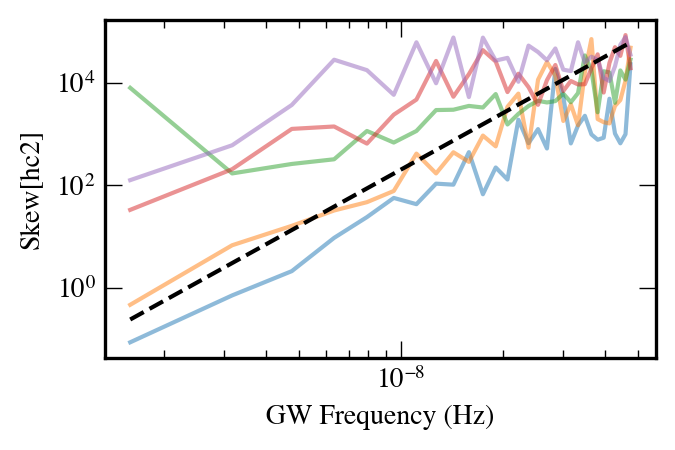

In [44]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

#fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True,)

kurt = kurtosis(h2cf, axis=0, nan_policy='omit')

for ii in range(h2cf.shape[-1]):  # plot models
    plt.plot(freqs, kurt[:, ii], label=f'Model {ii}', alpha=0.5)
    
    #ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
    #axs[0].set_xscale('log')
    #axs[0].set_yscale('log') if quant != 'log_{10}(rho(f) [s])' else None
    #axs[0].set_ylabel(quant)
    #axs[0].set_xlabel(r'GW Frequency (Hz)')

plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylabel('Skew[hc2]')
plt.xlabel(r'GW Frequency (Hz)')

plt.plot(freqs, 1.4e4 * (freqs/fyr)**(11/3), c='k', ls='--', label=r'$f^{11/3}$')

    #[axs[1].plot(freqs, amplitudes[q, jj], c='grey', alpha=0.25, ls='--')
    # for jj in range(20)]